#PhlyGreen Tutorial: sizing a parallel-hybrid aircraft 

Import packages

In [1]:
import sys
sys.path.insert(0,'../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [2]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)
battery = pg.Systems.Battery.Battery(None)
climateimpact = pg.ClimateImpact.ClimateImpact(None)

Create instance of Aircraft object.

In [3]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake, battery, climateimpact)

Create the connections with its subsystems.

In [4]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft
battery.aircraft = myaircraft
climateimpact.aircraft = myaircraft

Define input dictionaries

In [5]:
ConstraintsInput = {'DISA': 0.,
                    'Cruise': {'Speed': 0.5, 'Speed Type':'Mach', 'Beta': 0.95, 'Altitude': 8000.},
                    'AEO Climb': {'Speed': 210, 'Speed Type':'KCAS', 'Beta': 0.97, 'Altitude': 6000., 'ROC': 5},
                    'OEI Climb': {'Speed': 1.2*34.5, 'Speed Type': 'TAS', 'Beta': 1., 'Altitude': 0., 'Climb Gradient': 0.021},
                    'Take Off': {'Speed': 90, 'Speed Type': 'TAS', 'Beta': 1., 'Altitude': 100., 'kTO': 1.2, 'sTO': 950},
                    'Landing':{'Speed': 59., 'Speed Type': 'TAS', 'Altitude': 500.},
                    'Turn':{'Speed': 210, 'Speed Type': 'KCAS', 'Beta': 0.9, 'Altitude': 5000, 'Load Factor': 1.1},
                    'Ceiling':{'Speed': 0.5, 'Beta': 0.8, 'Altitude': 9500, 'HT': 0.5},
                    'Acceleration':{'Mach 1': 0.3, 'Mach 2':0.4, 'DT': 180, 'Altitude': 6000, 'Beta': 0.9}}

In [6]:
MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.97,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

In [7]:
MissionStages = {'Takeoff': {'Supplied Power Ratio':{'phi': 0.}},
                'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0, 'phi_end':0}},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 120, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0, 'phi_end':0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.07, 'Speed': 125, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0, 'phi_end':0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.4, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0, 'phi_end':0.5}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.35, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}


In [8]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Contingency Fuel': 130,
                   'Ebat': 700 * 3600,
                   'pbat': 1000,
                   'Eta Gas Turbine Model': 'constant',
                   'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive Model': 'constant',
                   'Eta Propulsive': 0.9,
                   'Eta Electric Motor 1': 0.96,    #for serial config
                   'Eta Electric Motor 2': 0.96,    #for serial config
                   'Eta Electric Motor': 0.98,      #for parallel config
                   'Eta PMAD': 0.99,
                   'Specific Power Powertrain': [3900,7700],
                   'Specific Power PMAD': [2200,2200,2200],
                   'PowertoWeight Battery': 35, 
                   'PowertoWeight Powertrain': [150,33],
                   'PowertoWeight PMAD': 0
                   }

In [9]:
CellInput = {
    'Class': "II",
    'Model':'Finger-Cell-Thermal',
    'SpecificPower': 8000,
    'SpecificEnergy': 1500,
    'Minimum SOC': 0.2,
    'Pack Voltage':800,
    'Initial temperature': 25,
    'Max operative temperature':50,
    'Ebat': 1000 * 3600, # PhlyGreen uses this input only if Class == 'I'
    'pbat': 1000
    }

In [10]:
AerodynamicsInput = {'AnalyticPolar': {'type': 'Quadratic', 'input': {'AR': 11, 'e_osw': 0.8}},
                    'Take Off Cl': 1.9,
                     'Landing Cl': 1.9,
                     'Minimum Cl': 0.20,
                     'Cd0': 0.017}


In [11]:
WellToTankInput = {'Eta Charge': 0.95,
                   'Eta Grid': 1.,
                   'Eta Extraction': 1.,
                   'Eta Production': 1.,
                   'Eta Transportation': 0.25}

ClimateImpactInput = {'H': 100, 'N':1.6e7, 'Y':30, 'EINOx_model':'Filippone', 'WTW_CO2': 8.30e-3, 'Grid_CO2': 9.36e-2}

Set aircraft power configuration and structural weight model 

In [12]:
myaircraft.Configuration = 'Hybrid'
myaircraft.HybridType = 'Parallel'
myaircraft.weight.Class = 'I'
myaircraft.AircraftType = 'ATR'

Import input dictionaries

In [13]:
myaircraft.ReadInput(AerodynamicsInput, 
                     ConstraintsInput,
                     MissionInput,
                     EnergyInput,
                     MissionStages,
                     DiversionStages, 
                     LoiterStages=None, 
                     WellToTankInput=WellToTankInput, 
                     CellInput=CellInput, 
                     ClimateImpactInput=ClimateImpactInput, 
                     PropellerInput=None
                     )

Either run the Constraint Analysis....

In [14]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------------')
print(f'Design wing loading W/S: {myaircraft.DesignWTOoS:.1f} [N/m^2]')
print(f'Design power-to-mass ratio P/W: {myaircraft.DesignPW:.2f} [W/kg]')
print('----------------------------------------------')

----------------------------------------------
Design wing loading W/S: 3293.8 [N/m^2]
Design power-to-mass ratio P/W: 194.91 [W/kg]
----------------------------------------------


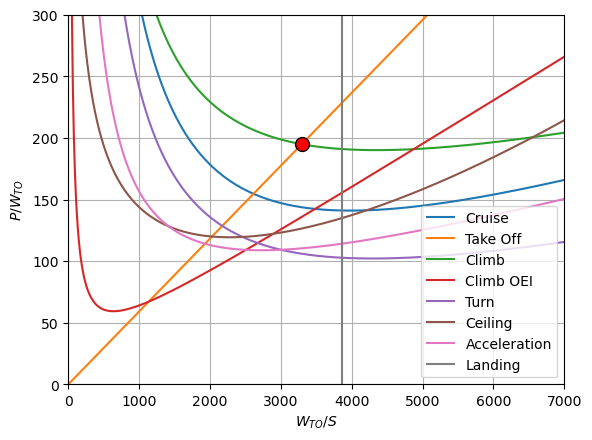

In [15]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAEOClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEIClimb, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$P/W_{TO}$')
plt.show()

... or manually assign a wing loading

In [47]:
# myaircraft.DesignWTOoS = 3323

Run Mission analysis to define the aircraft's masses

In [16]:
myaircraft.weight.WeightEstimation()

max=58 and min=56
Optimal n 57
max=341 and min=340
Optimal n 341
max=119 and min=118
Optimal n 119
max=125 and min=124
Optimal n 125
max=125 and min=124
Optimal n 125
max=125 and min=124
Optimal n 125
max=125 and min=124
Optimal n 125


Wing surface can be readily estimated as S = WTO/(WTO/S)

In [ ]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * 9.81

Well to tank impact is evaluated as a post-process

In [18]:
if (myaircraft.Configuration == 'Hybrid' and WellToTankInput is not None):
    myaircraft.welltowake.EvaluateSource()

A summary of the preliminary design:

In [19]:
myaircraft.Print_Aircraft_Design_Summary()

Fuel mass (trip + altn + loiter): 1572.8 [Kg]
Block Fuel mass:                  1702.8 [Kg]
Battery mass:                     1686.2 [Kg]
Structure:                        12028.6 [Kg]
Powertrain mass:                  1432.9 [Kg]
Empty Weight:                     15647.8 [Kg]
Zero Fuel Weight:                 20207.8 [Kg]
----------------------------------------
Takeoff Weight:                   21910.5 [Kg]
 
Source Energy:                    281499.3 [MJ]
Psi:                              0.0278 [-]
 
Wing Surface:                     65.3 [m^2]
 
TakeOff engine shaft peak power:  4942.3 [KW]
CLB/CRZ engine shaft peak power:  4072.2 [KW] @ 1503.5 [m]
 
Sizing phase for thermal powertrain:  Takeoff peak power
Thermal powertrain rating shaft power SLS rating: 4942.3 [kW]
 
-------------Battery Specs-------------
Battery Pack Energy:               2529.4 [kWh]
Battery Pack Max Power:            13563.4 [kW]
Battery Pack Specific Energy:      1500.0 [Wh/kg]
Battery Pack Specific Power: 

Tank to wake climate impact is evaluated as a post-process 

In [51]:
myaircraft.MissionType = 'Continue'
myaircraft.climateimpact.calculate_mission_emissions()
print(myaircraft.climateimpact.mission_emissions)

myaircraft.climateimpact.ATR()


{'co2': 6271.132330574286, 'h2o': 1981.7050949308777, 'so4': 0.31455636427474254, 'soot': 0.0629112728549485, 'nox': 19.691019794255674}


0.002813568623143991

Some plots:

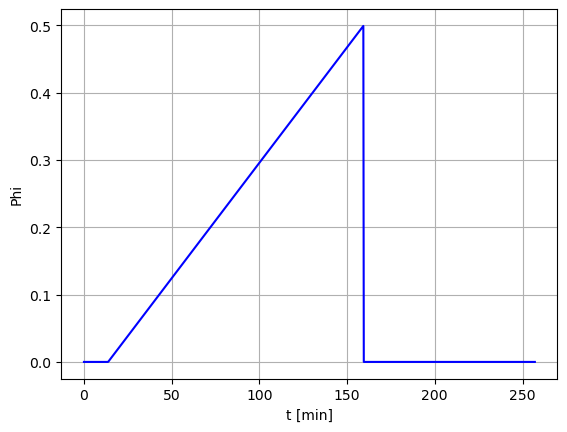

In [20]:
times = np.linspace(0,mission.profile.MissionTime2,num = 1000)
plt.plot(times/60,[mission.profile.SuppliedPowerRatio(t) for t in times], 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Phi')
plt.show()

In [21]:
times = np.array([])
Ef    = np.array([])
Ebat  = np.array([])
beta  = np.array([])
soc   = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef    = np.concatenate([Ef   , array.y[0]])
    Ebat  = np.concatenate([Ebat , array.y[1]])
    beta  = np.concatenate([beta , array.y[2]])

Takeoff propulsive power

In [22]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.TakeOffConstraints['Beta'], myaircraft.constraint.TakeOffConstraints['Altitude'],myaircraft.constraint.TakeOffConstraints['kTO'], myaircraft.constraint.TakeOffConstraints['sTO'], myaircraft.constraint.DISA, myaircraft.constraint.TakeOffConstraints['Speed'], myaircraft.constraint.TakeOffConstraints['Speed Type'])

194.88837279163596

Maximum mission Propusive Power over Takeoff Mass

In [23]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

160.5799464672633

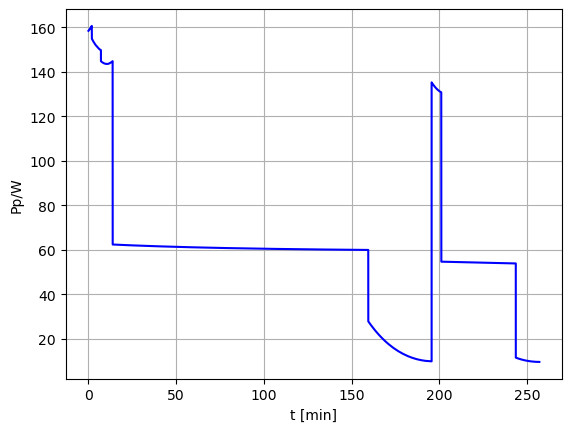

In [24]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

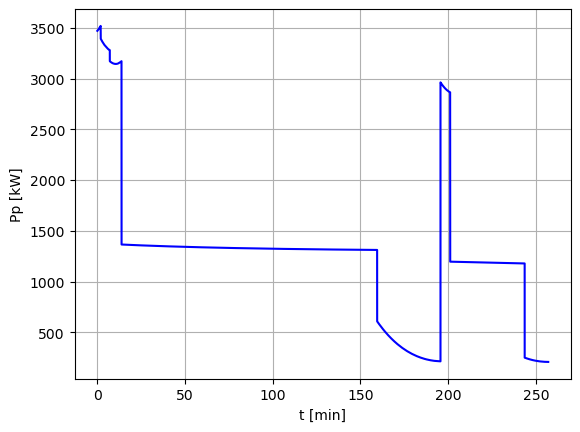

In [25]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp [kW]')
plt.show()

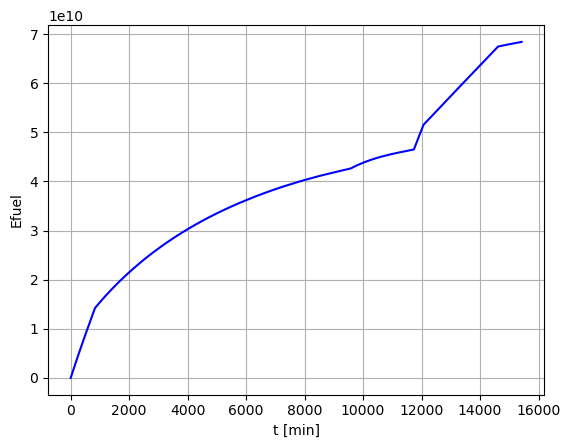

In [26]:
plt.plot(times,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

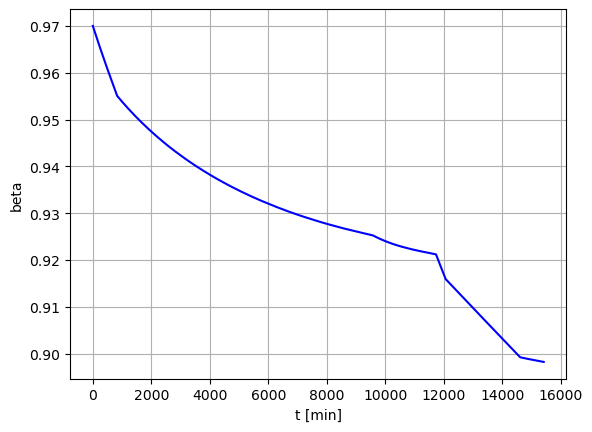

In [27]:
plt.plot(times,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

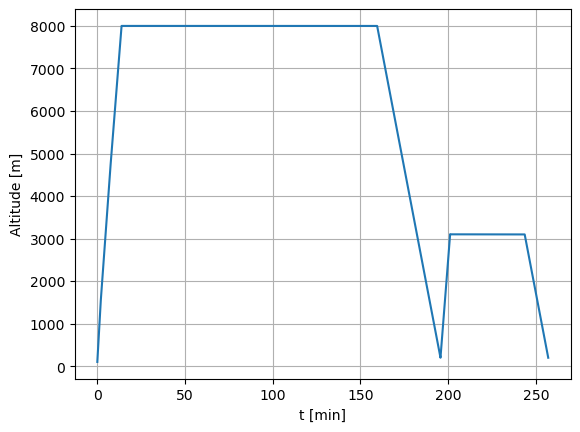

In [28]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()
